## Building load forecasting: Hospital in SF

We can train a forecaster on another commom energy problem. In this, case we are training a 1-step ahead forecaster to predict the electricity consumption of a building.

The dataset contains one year of hourly observations.
The training will occur on 11 months of the data, reserving the last month for evaluation.

In [1]:
!pip3 install pandas -q
!pip3 install neuralprophet -q
!pip3 install livelossplot -q
!pip3 install hyperopt -q

In [2]:
import urllib
import os
import pickle
import pandas as pd
from neuralprophet import NeuralProphet
from zipfile import ZipFile
import requests
from hyperopt import hp, fmin, tpe, space_eval

## Data Collection & Preparation
Downloading and loading the data into Pandas Dataframes, then creating a 'ds' and 'y' for Prophet to fit.

In [3]:
#download the dataset and save it
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00501/PRSA2017_Data_20130301-20170228.zip"
r = requests.get(url, allow_redirects=True)

open('data.zip', 'wb').write(r.content)

7959991

In [4]:
zip_file = ZipFile('data.zip')
files = zip_file.infolist()

#read one city into a data frame
df_a = pd.read_csv(zip_file.open(files[8].filename))

#composite dataframe of all the cities in the dataset
df = pd.read_csv(zip_file.open(files[1].filename))
for i in files[2:]:
    df = pd.concat([df, pd.read_csv(zip_file.open(i.filename))])

In [5]:
df_a.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,5.0,14.0,4.0,12.0,200.0,85.0,-0.5,1024.5,-21.4,0.0,NNW,5.7,Nongzhanguan
1,2,2013,3,1,1,8.0,12.0,6.0,14.0,200.0,84.0,-0.7,1025.1,-22.1,0.0,NW,3.9,Nongzhanguan
2,3,2013,3,1,2,3.0,6.0,5.0,14.0,200.0,83.0,-1.2,1025.3,-24.6,0.0,NNW,5.3,Nongzhanguan
3,4,2013,3,1,3,5.0,5.0,5.0,14.0,200.0,84.0,-1.4,1026.2,-25.5,0.0,N,4.9,Nongzhanguan
4,5,2013,3,1,4,5.0,5.0,6.0,21.0,200.0,77.0,-1.9,1027.1,-24.5,0.0,NNW,3.2,Nongzhanguan


In [6]:
#prophet wants a 'ds' column with the time, let's create it out of the 4 columns
df_a['ds'] = pd.to_datetime(df_a.rename(columns={'Date':'Day'})[['hour','day','month','year']])

<AxesSubplot:>

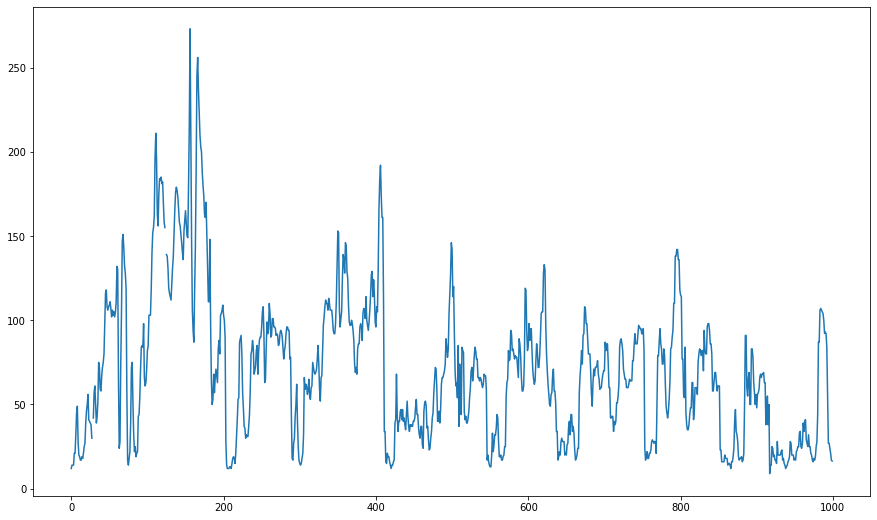

In [7]:
#our target has to be named 'y', we want to predict no2
df_a = df_a.rename(columns={'NO2':'y'})
#a sample of the readings
df_a[:1000]["y"].plot(figsize=(15,9))

In [8]:
#this dataset has almost 700 missing values, we don't have to fill these for this model
df_a[df_a["y"].isna()]

,No,year,month,day,hour,PM2.5,PM10,SO2,y,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station,ds
28,29,2013,3,2,4,3.0,6.0,7.0,NaN,400.0,59.0,-3.1,1032.7,-16.1,0.0,N,0.0,Nongzhanguan,2013-03-02 04:00:00
124,125,2013,3,6,4,153.0,175.0,87.0,NaN,1899.0,35.0,5.1,1009.5,-6.5,0.0,NE,1.0,Nongzhanguan,2013-03-06 04:00:00
1084,1085,2013,4,15,4,52.0,155.0,21.0,NaN,1000.0,5.0,5.5,1000.5,-1.7,0.0,ENE,0.6,Nongzhanguan,2013-04-15 04:00:00
1180,1181,2013,4,19,4,67.0,105.0,39.0,NaN,1100.0,30.0,7.1,1021.0,-4.7,0.0,SE,1.8,Nongzhanguan,2013-04-19 04:00:00
1276,1277,2013,4,23,4,85.0,101.0,15.0,NaN,800.0,46.0,10.0,1007.0,6.7,0.0,S,2.0,Nongzhanguan,2013-04-23 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34959,34960,2017,2,24,15,14.0,29.0,7.0,NaN,400.0,NaN,11.8,1018.8,-13.3,0.0,WSW,1.8,Nongzhanguan,2017-02-24 15:00:00
34986,34987,2017,2,25,18,NaN,NaN,NaN,NaN,NaN,NaN,11.4,1016.4,-12.1,0.0,NNW,2.6,Nongzhanguan,2017-02-25 18:00:00
35006,35007,2017,2,26,14,NaN,NaN,NaN,NaN,NaN,NaN,12.4,1018.9,-8.8,0.0,ESE,1.6,Nongzhanguan,2017-02-26 14:00:00
35026,35027,2017,2,27,10,NaN,NaN,NaN,NaN,NaN,NaN,6.8,1019.3,-5.2,0.0,E,1.9,Nongzhanguan,2017-02-27 10:00:00


## Fit a basic model
This model is very similar to classical prophet.

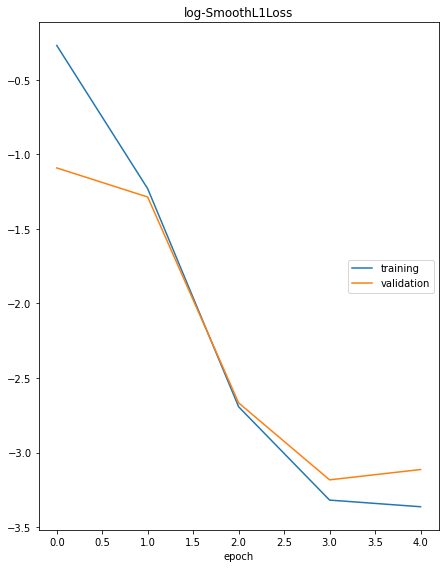

Epoch[6/77]:   8%|▊         | 6/77 [00:05<01:03,  1.12it/s, SmoothL1Loss=0.0346, MAE=25, RMSE=32.5, RegLoss=0, MAE_val=29.6, RMSE_val=36.8, SmoothL1Loss_val=0.0445]

In [ ]:
#fit a model
m = NeuralProphet(
    trend_reg=1,
    learning_rate=0.03,
)
df_train, df_test = m.split_df(df_a[["ds","y"]], freq='H', valid_p = 1.0/12)

print(len(df_train), len(df_test))

metrics = m.fit(df_train, freq='H', validation_df=df_test, plot_live_loss=True)

In [ ]:
metrics.tail(1)

In [ ]:
forecast = m.predict(df_train)
fig = m.plot(forecast)

In [ ]:
forecast = m.predict(df_test)
m = m.highlight_nth_step_ahead_of_each_forecast(1)
fig = m.plot(forecast[-3*30:])

In [ ]:
#various parameters fit to identify the trend
fig_param = m.plot_parameters()

## 1-step ahead forecast with Auto-Regression
We'll train a model that predicts one day's emissions at a time and uses the last 18 readings while doing so.

In [ ]:
#model doesn't automatically impute many consecutive missing values
df_a["y"] = df_a['y'].fillna(df_a["y"].mean())

In [ ]:
m = NeuralProphet(
    growth='off',
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    n_lags=24,
    ar_sparsity=0.95,
    learning_rate = 0.003,
)

df_train, df_test = m.split_df(df_a[["ds","y"]], freq='H', valid_p = 1.0/12)

metrics = m.fit(df_train, freq='H', validation_df=df_test, plot_live_loss=True)

In [ ]:
metrics.tail(1)

In [ ]:
forecast = m.predict(df_train)
fig = m.plot(forecast)

In [ ]:
forecast = m.predict(df_test)
m = m.highlight_nth_step_ahead_of_each_forecast(1)
fig = m.plot(forecast[-7*24:])

In [ ]:
fig_param = m.plot_parameters()

## 1-Step ahead forecast with AR-Net: Using a Neural Network
Now we will include a neural network to generate predictions

In [ ]:
m = NeuralProphet(
    growth='off',
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    n_lags=24,
    num_hidden_layers=4,
    d_hidden=16,
    learning_rate=0.003,
)

metrics = m.fit(df_train, freq='H', validation_df=df_test, plot_live_loss=True)

In [ ]:
metrics.tail(1)

In [ ]:
forecast = m.predict(df_train)
fig = m.plot(forecast)

In [ ]:
forecast = m.predict(df_test)
m = m.highlight_nth_step_ahead_of_each_forecast(1)
fig = m.plot(forecast[-7*24:])

In [ ]:
fig_comp = m.plot_parameters()

## 24-Step ahead using a Neural Net
We will use the last 3 days of readings to predict 24 hours of measurements at a time

In [ ]:
m = NeuralProphet(
    trend_reg=2,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
    n_lags=24*3,
    n_forecasts = 24,
    num_hidden_layers=4,
    d_hidden=16,
    learning_rate=0.003,
)

metrics = m.fit(df_train, freq='H', validation_df=df_test, plot_live_loss=True)

In [ ]:
metrics.tail(1)

In [ ]:
forecast = m.predict(df_train)
fig = m.plot(forecast)

In [ ]:
forecast = m.predict(df_test)
m = m.highlight_nth_step_ahead_of_each_forecast(1)
fig = m.plot(forecast[-7*24:])

In [ ]:
m = m.highlight_nth_step_ahead_of_each_forecast(1)
fig_param = m.plot_parameters()

## Making predictions
Future dataframe adds the number of future steps specified by the model (in this case 24).
Raw returns one array of predictions, rather than a staggered dataframe.

In [ ]:
m.predict(m.make_future_dataframe(df_a[['ds','y']]),decompose=False,raw=True)

## Additional Regressors
Providing additional data for the model to include in forecasting

In [ ]:
m = NeuralProphet(
    growth='on',
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
    n_lags=24*3,
    n_forecasts = 24,
    num_hidden_layers=4,
    d_hidden=16,
    learning_rate=0.003,
)
m = m.add_lagged_regressor('WSPM')
m = m.add_lagged_regressor('TEMP')

df_train_ar, df_test_ar = m.split_df(df_a[["ds","y","WSPM","TEMP"]], freq='H', valid_p = 1.0/12)

metrics = m.fit(df_train_ar, freq='H', validation_df=df_test_ar, plot_live_loss=True)

## Training all models
Prophet can't train using overlapping date ranges, so we can train a model for each city and its emissions and store them, loading the appropriate model for inferencing

In [ ]:
stations = df['station'].unique()
df['ds'] = pd.to_datetime(df.rename(columns={'Date':'Day'})[['hour','day','month','year']])
df = df.rename(columns={'NO2':'y'})
df["y"] = df['y'].fillna(df["y"].mean())

if not os.path.exists('models'):
    os.makedirs('models')

m_s = NeuralProphet(
    trend_reg=2,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
    n_lags=24*3,
    n_forecasts = 24,
    num_hidden_layers=4,
    d_hidden=16,
    learning_rate=0.003,)

for s in stations:
    print(s)
    df_t = df[df['station']==s]
    df_train_t, df_test_t = m_s.split_df(df_t[["ds","y"]], freq='H', valid_p = 1.0/12)
    metrics = m_s.fit(df_train_t, freq='H', validation_df=df_test_t, plot_live_loss=False)
    with open('models/'+s+'.pkl', "wb") as f:
        pickle.dump(m_s, f)

In [ ]:
!ls models

In [ ]:
#loading one of the models
with open('models/Changping.pkl', "rb") as f:
    m_x = pickle.load(f)

In [ ]:
#predicting
m_x.predict(m_x.make_future_dataframe(df[df['station']=='Changping'][['ds','y']]),decompose=False,raw=True)